# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$.
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки.
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вершину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии.

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [22]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

Код для расчёта энтропии:

In [23]:
def entropy(y):

    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер.

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения узлов дерева (используйте, например, `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признаков и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три разных критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [24]:
def information_gain(y, y_left, y_right):
    main_entropy = entropy(y)

    left_entropy = entropy(y_left)
    right_entropy = entropy(y_right)

    left_weight = len(y_left) / len(y)
    right_weight = len(y_right) / len(y)

    _information_gain = main_entropy - (left_weight * left_entropy + right_weight * right_entropy)

    return _information_gain

class Node:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None
        self.answer = None

def stop_criteria(y, depth, max_depth=None, min_samples_leaf=1, purity=False):
    if purity and len(np.unique(y)) == 1:
        return True

    if max_depth and depth >= max_depth:
        return True

    if len(y) < min_samples_leaf:
        return True

    return False

def best_split(X, y):
    best_information_gain = 0
    best_feature_index = None
    best_threshold = None

    for feature_index in X.columns:
        for threshold in X[feature_index]:
            left = X[feature_index] < threshold
            right = X[feature_index] >= threshold

            _information_gain = information_gain(y, y[left], y[right])

            if _information_gain > best_information_gain:
                best_information_gain = _information_gain
                best_feature_index = feature_index
                best_threshold = threshold

    return best_feature_index, best_threshold

def split_node(X, y, depth=1, max_depth=None, min_samples_leaf=1, purity=False):
    node = Node()

    if stop_criteria(y, depth, max_depth, min_samples_leaf, purity):
        node.answer = np.bincount(y).argmax()
        return node

    feature_index, threshold = best_split(X, y)

    if feature_index is None:
        node.answer = np.bincount(y).argmax()
        return node

    left = X[feature_index] < threshold
    right = X[feature_index] >= threshold

    node.feature_index = feature_index
    node.threshold = threshold
    node.left = split_node(X[left], y[left], depth + 1, max_depth, min_samples_leaf, purity)
    node.right = split_node(X[right], y[right], depth + 1, max_depth, min_samples_leaf, purity)

    return node

def build_tree(X, y, max_depth=None, min_samples_leaf=1, purity=False):
    root = split_node(X, y, max_depth=max_depth, min_samples_leaf=min_samples_leaf, purity=purity)
    return root

def predict_node(node, X):
    if node.answer is not None:
        return node.answer

    if X[node.feature_index] < node.threshold:
        return predict_node(node.left, X)
    else:
        return predict_node(node.right, X)

def predict(tree, X):
    predictions = []
    for index, row in X.iterrows():
        prediction = predict_node(tree, row)
        predictions.append(prediction)
    return predictions

In [25]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_max_depth = build_tree(X_train, y_train, max_depth=5)
tree_min_samples_leaf = build_tree(X_train, y_train, min_samples_leaf=5)
tree_purity = build_tree(X_train, y_train, purity=True)

predictions_max_depth = predict(tree_max_depth, X_test)
predictions_min_samples_leaf = predict(tree_min_samples_leaf, X_test)
predictions_purity = predict(tree_purity, X_test)

accuracy_max_depth = accuracy_score(y_test, predictions_max_depth)
accuracy_min_samples_leaf = accuracy_score(y_test, predictions_min_samples_leaf)
accuracy_purity = accuracy_score(y_test, predictions_purity)

print("Accuracy (max_depth) on test data:", accuracy_max_depth)
print("Accuracy (min_samples_leaf) on test data:", accuracy_min_samples_leaf)
print("Accuracy (purity) on test data:", accuracy_purity)

Accuracy (max_depth) on test data: 1.0
Accuracy (min_samples_leaf) on test data: 0.9777777777777777
Accuracy (purity) on test data: 0.9777777777777777


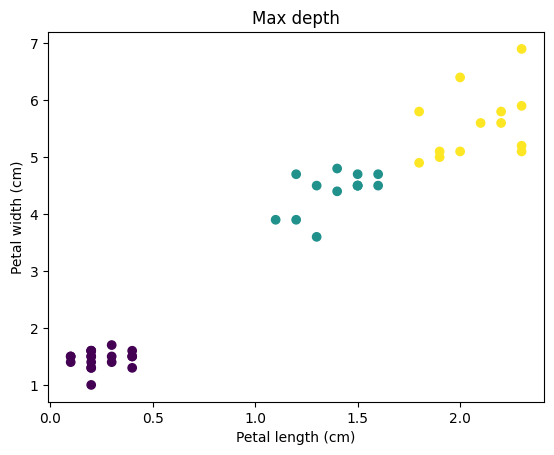

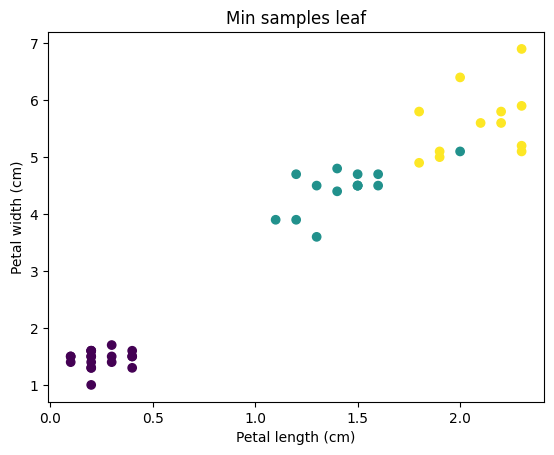

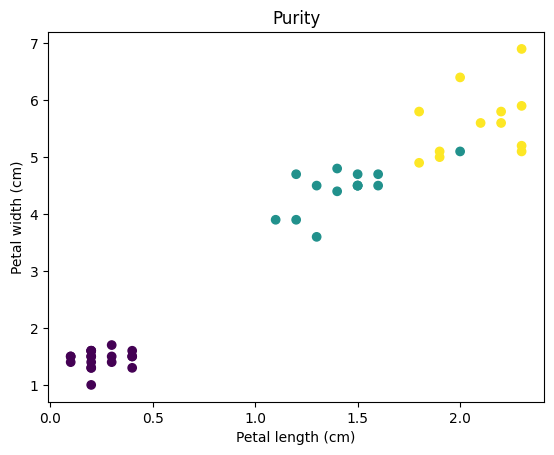

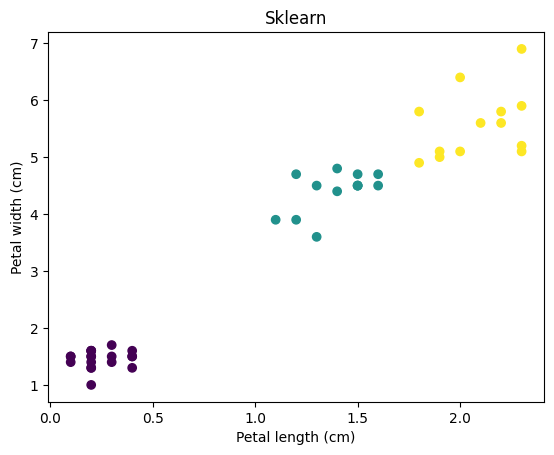

In [26]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)
predictions_sklearn = classifier.predict(X_test)

predictions_max_depth = predict(tree_max_depth, X_test)
predictions_min_samples_leaf = predict(tree_min_samples_leaf, X_test)
predictions_purity = predict(tree_purity, X_test)


def plot_predictions(X, y_pred, title):
    plt.scatter(X['petal width (cm)'], X['petal length (cm)'], c=y_pred)
    plt.title(title)
    plt.xlabel('Petal length (cm)')
    plt.ylabel('Petal width (cm)')
    plt.show()

plot_predictions(X_test, predictions_max_depth, "Max depth")
plot_predictions(X_test, predictions_min_samples_leaf, "Min samples leaf")
plot_predictions(X_test, predictions_purity, "Purity")
plot_predictions(X_test, predictions_sklearn, "Sklearn")


После оценки точности можно сделать вывод, что точности моделей с минимального числа объектов в листе = 5 и purity на 3% хуже, чем моделей из sklearn и максимальной глубины дерева = 5.
Это происходит из-за того, что ограничение минимального числа объектов в листе приводит к менее гибкой модели, которая не сможет точно разделить данные на классы, происходит переобучение.
А ограничение purity приводит либо к переобучению модели или же недообучению, что также влияет на качество выходных данных. Каждый лист дерева будет содержать только объекты одного класса, что может привести к очень сложной модели, которая будет плохо работать на новых данных.


##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


In [27]:
class ForestClassifier:
  def __init__(self, tree_count, tree_max_depth, tree_min_samples_leaf):
        self.tree_count = tree_count
        self.tree_max_depth = tree_max_depth
        self.tree_min_samples_leaf = tree_min_samples_leaf
        self.trees = []

def build_forest(forest, X, y):
    objects_count = X.shape[0]
    features_count = X.shape[1]

    for _ in range(forest.tree_count):
        sample_indexes = np.random.choice(objects_count, size=objects_count, replace=True)
        X_bootstrap = X.iloc[sample_indexes]
        y_bootstrap = y.iloc[sample_indexes]

        sklearn_tree = DecisionTreeClassifier(max_depth=forest.tree_max_depth, min_samples_leaf=forest.tree_min_samples_leaf, max_features=int(np.sqrt(features_count)))

        sklearn_tree.fit(X_bootstrap, y_bootstrap)

        forest.trees.append(sklearn_tree)

    return forest

def predict(forest, X):
    predictions = []
    for tree in forest.trees:
        prediction = tree.predict(X)
        predictions.append(prediction)

    mean_predictions = np.mean(predictions, axis=0)

    rounded_predictions = np.round(mean_predictions).astype(int)

    return rounded_predictions

def feature_importances(forest):
    importances = []
    for tree in forest.trees:
        importances.append(tree.feature_importances_)
    mean_importances = np.mean(importances, axis=0)

    return mean_importances


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес".

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [28]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [29]:
churn = pd.read_csv("/content/drive/MyDrive/data/churn.csv", sep = ",")

churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [30]:
y_target = churn['Exited']

In [31]:
churn = churn.drop(churn.columns[0:3], axis=1)
churn = churn.drop(churn.columns[-1], axis=1)
churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [32]:
mapping = {'HasCrCard':'HasCreditCard'}
churn = churn.rename(columns=mapping)
churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [33]:
X = churn.iloc[:, :-1]
X = pd.get_dummies(X)
X.head()

X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size = 0.33, random_state = 42)

In [34]:
def searching_hyperparameters(X_train, y_train, X_test, y_test, tree_count, tree_max_depth, tree_min_samples_leaf):
    forest = ForestClassifier(tree_count, tree_max_depth, tree_min_samples_leaf)
    forest = build_forest(forest, X_train, y_train)
    y_pred = predict(forest, X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

def get_best_hyperparameters(X_train, y_train, X_test, y_test):
    best_accuracy = 0
    best_params = {}

    tree_count_values = [10, 50, 75, 100, 200, 500]
    tree_max_depth_values = list(range(1, 10))
    tree_min_samples_leaf_values = list(range(1, 7))

    for tree_count in tree_count_values:
        for tree_max_depth in tree_max_depth_values:
            for tree_min_samples_leaf in tree_min_samples_leaf_values:
                accuracy = searching_hyperparameters(X_train, y_train, X_test, y_test, tree_count, tree_max_depth, tree_min_samples_leaf)

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'tree_count': tree_count,
                        'tree_max_depth': tree_max_depth,
                        'tree_min_samples_leaf': tree_min_samples_leaf,
                        'accuracy': accuracy }

    return best_params

best_params = get_best_hyperparameters(X_train, y_train, X_test, y_test)
best_params

{'tree_count': 200,
 'tree_max_depth': 9,
 'tree_min_samples_leaf': 6,
 'accuracy': 0.8751515151515151}

In [35]:
forest = ForestClassifier(best_params['tree_count'], best_params['tree_max_depth'], best_params['tree_min_samples_leaf'])
forest = build_forest(forest, X_train, y_train)

y_pred = predict(forest, X_test)

In [36]:
feature_names = X_test.columns
importance_values = feature_importances(forest)
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance_values})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

feature_importance_df

,feature,importance
1,Age,0.345296
4,NumOfProducts,0.246633
3,Balance,0.104377
6,IsActiveMember,0.084187
0,CreditScore,0.074865
8,Geography_Germany,0.044226
2,Tenure,0.042793
11,Gender_Male,0.012856
10,Gender_Female,0.012596
7,Geography_France,0.011930


In [37]:
from sklearn.ensemble import RandomForestClassifier

sklearn_model = RandomForestClassifier(n_estimators=best_params['tree_count'], max_depth=best_params['tree_max_depth'], min_samples_leaf=best_params['tree_min_samples_leaf'], random_state=42)

sklearn_model.fit(X_train, y_train)

sklearn_y_pred = sklearn_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, sklearn_y_pred)}')

Accuracy: 0.8736363636363637


In [38]:
feature_names = X_test.columns
importance_values = sklearn_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance_values})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

feature_importance_df

,feature,importance
1,Age,0.358507
4,NumOfProducts,0.252386
3,Balance,0.102923
6,IsActiveMember,0.077969
0,CreditScore,0.064763
8,Geography_Germany,0.046203
2,Tenure,0.039454
10,Gender_Female,0.014481
7,Geography_France,0.012533
11,Gender_Male,0.012472


Можно сделать вывод, что модель из sklearn работает лучше с параметрами:
Количество деревьев : 500,
Максимальная глубина дерева : 9,
Минимальное количество объектов в листе: 2

Порядок важности признаков почти одинаковый, отличаются только незначительно признаки пола. Самые важные признаки - Возраст, Количество объектов, которые приобрел клиент через банк, а также баланс на счете.